# Challenge 02: Minimum Hamming Distance using a Quantum Algorithm

The Hamming distance between two binary strings (with the same number of bits) is defined as the number positions where the bits differ from each other. For example, the Hamming distance between these $6$-bit strings <span style="color:red">$0$</span>$01$<span style="color:red">$0$</span>$0$<span style="color:red">$1$</span> and <span style="color:red">$1$</span>$01$<span style="color:red">$1$</span>$0$<span style="color:red">$0$</span> is $3$.

A simple way to calculate the Hamming distance between two numbers is to perform a bitwise XOR between them, and count the number of ones in the resulting string:

$$ 001001 \oplus 101100 = 100101 \xrightarrow[]{\; \text{count ones} \;} 011 \text{ (3 in base-2)} $$

The purpose of this challenge is to develop a quantum algorithm that takes as an input an arbitrary number $m$ of $n$-bit strings, and outputs the two strings with the minimum Hamming distance between them with a resonably high probability. How high? the higher the better.

For instance, for the following input of four 4-bit strings: $[0000,1001,1100,1101]$ the algorithm should return strings $[1100,1101]$ since they only differ by one bit.

**Level 1:** Start by only considering the cases in which the answer is unique. In other words, assume that all inputs only have one pair of strings that gives the minimum Hamming distance. So inputs such as $[0000,0001,0010,0111]$ don't have to be considered because there are two solutions: $[0000,0001]$ and $[0000,0010]$.

**Level 2:** Now consider the case where more than one solution can exist and make sure the algorithm returns each of the possible solutions with equal probability. So, for the example above, the probability of measuring $[0000,0001]$ or $[0000,0010]$ should be close to $50\%$ (inputs with repeated strings should also be considered).

**Hint:** Consider looking into some of the "textbook" quantum algorithms (like Deutch-Jozsa (DJ) [1], Bernstein-Vazirani (BV) [2], Grover [3], etc.) to see if this problem can be solved with variations of these. Take for instance this pre-print [4], where a modified version of DJ was used to compute Hamming distances between two strings. Now, keep in mind that in that approach, Hamming weights were calculated using probability distributions (which require multiple runs of the algorithm), and not by amplifying states, as required by this challenge.


[1] Deutsch, David, and Richard Jozsa. "Rapid solution of problems by quantum computation." Proceedings of the Royal Society of London. Series A: Mathematical and Physical Sciences 439.1907 (1992): 553-558.

[2] Bernstein, Ethan, and Umesh Vazirani. "Quantum complexity theory." SIAM Journal on computing 26.5 (1997): 1411-1473.

[3] Grover, Lov K. , "A fast quantum mechanical algorithm for database search", Proceedings of the 28th Annual ACM Symposium on the Theory of Computing (1996), [arXiv:quant-ph/9605043](https://arxiv.org/abs/quant-ph/9605043)

[4] Bravo, José Manuel. "Calculating Hamming distance with the IBM Q Experience." Preprints (2018).

# My Solution

Developed by [Shiro-Raven](https://github.com/Shiro-Raven)

## The Theory

Our problem can be formulated as follows: *Given a set $\mathbf{S}$, find the set $\mathbf{X} = \{(s_i, s_j) \in \mathbf{S} \times \mathbf{S}\ | ham(s_i, s_j) = \min_{\forall(s_i, s_j) \in \mathbf{S} \times \mathbf{S}} ham(s_i, s_j)\}$*

I decided to use a variation of Grover's algorithm augemented with QRAMs to carry out search through the input list. Since we are looking for a pair of elements, I used two QRAMs to store a copy of the input list each. 

The oracle of Grover's consists of several components:
1. A Logical XOR unit that carries calculates the exclusive-or on the two data registers of the QRAMs. 
2. A Logical Counter unit that counts the number of 1's in the result of the XOR.
3. A "Fixed" Logical Comparator that compares the value of the counter against a predetermined value. In our case, the output qubit is $1$ if the input register is less than the fixed value.
4. A normal Logical Comparator that compares the the two address registers of the QRAMs. In our case, it outputs $1$ if register $B$ has a value smaller than that of register $A$.

The output of numbers 3 and 4 are used as controls for the oracle flip qubit.

Despite not relevant to the logic of the algorithm, number 4 is necessary for the "self-augmentation" of the search space, since $M$, the number of solutions, can't be determined before running the algorithm. Thus, the oracle leaves all pairs $(a_i, a_j)$ unscathed if $i \geq j$ even when $(a_i, a_j)$ satisfy our query. This ensures that the algorithm always works as expected, no matter the number of correct solutions.

The algorithm I devised is hybrid, and it goes like this:
1. Classically, pick two random elements from the input list, and calculate their Hamming distance, $currMinHam$, and store it.
2. Construct the quantum circuit implemnting Grover's algorithm using $currMinHam$ as the "fixed" value of the comparator in number 3 above, and setup the QRAMs based on the input list.
3. Run the circuit for a set number of shots, measuring the value of the address register. I found $10$ to be sufficient for getting a correct result, but the value should be higher as the input size increases.
4. Filter out the invalid results; those with $i \geq j$, if exist.
5. From the remaining results, get the one with the highest frequency, and get the corresponding elements from the list. 
6. Calculate the Hamming distance of the guessed elements:
    1. If it is less than $currMinHam$, set $currMinHam$ to that value and go to 2.
    2. If it is equal or greater, return the pair of elements and break. Optionally, one can loop over the results in descending order of the counts, outputting the pairs whose Hamming distance is equal to $currMinHam$.
    
Only one oracle query was sufficient for the input list sizes constrainted by Qiskit's QASM simulator.

The algorithm has a time complexity of $O(N log(N))$, where $N$ is the size of the input. In terms of needed qubits, the algorithm requires $\Omega(3M + 2\left \lceil log_2 M  \right \rceil + 3\left \lceil log_2 \left |  N \right |  \right \rceil + 5)$ qubits, where $M$ is the index of the most significant **set** bit in any of the elements of the input, plus one.

## The Code

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from qiskit.visualization import plot_histogram
from qiskit import BasicAer, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.circuit.library import IntegerComparator

import math

### A. Required Mini-Circuits 

#### The QRAM 

In [2]:
def setup_qram(input_list):
    needed_addr = int(math.log(len(input_list), 2))
        
    needed_data = len(bin(max(input_list))[2:])

    address = QuantumRegister(needed_addr, 'address')
    data = QuantumRegister(needed_data, 'data')
    
    qc = QuantumCircuit(address,data)

    for (index, val) in enumerate(input_list):
        for (i, bit) in enumerate(format(index, '#0' + str(needed_addr + 2) + 'b')[2:]):
            if bit == '0':
                qc.x(address[needed_addr - 1 - i])

        for (i, bit) in enumerate(format(val, '#0' + str(needed_data + 2) + 'b')[2:]):
            if bit == '1':
                qc.mcx(address,data[needed_data - 1 - i])

        for (i, bit) in enumerate(format(index, '#0' + str(needed_addr + 2) + 'b')[2:]):
            if bit == '0':
                qc.x(address[needed_addr - 1 - i])
        
    U_s = qc.to_gate()
    U_s.name = "$QRAM$"
    
    return U_s

#### n-Bit NOK Comparator

In [3]:
def comparator_nok(register_size):
    def comp_bit(circ, data_1, data_2, aux, index):
        circ.cx(aux[index], data_2[index])
        circ.ccx(data_2[index], aux[index], aux[index + 1])
        circ.cx(data_1[index], data_2[index])
        circ.ccx(data_1[index], data_2[index], aux[index + 1])

    data_1 = QuantumRegister(register_size, 'data_1')
    data_2 = QuantumRegister(register_size, 'data_2')
    aux = QuantumRegister(register_size + 1, 'aux')
    noteq = QuantumRegister(1, 'ext')

    qc = QuantumCircuit(data_1, data_2, aux, noteq)

    qc.x(noteq)

    for i in range(register_size):
        comp_bit(qc, data_1, data_2, aux, i)
    
    qc.x(data_2)
    qc.mcx([x for x in data_2], noteq)

    U_c = qc.to_gate()
    U_c.name = "$NOK Comparator$"
    
    return U_c

#### Counter

In [4]:
def create_counter(inputs):
    flip = QuantumRegister(inputs)
    
    needed_bits = math.ceil(math.log(inputs, 2))
    
    if math.log(inputs, 2) - math.ceil(math.log(inputs, 2)) == 0.:
        needed_bits += 1
    
    auxiliary = QuantumRegister(needed_bits)
    
    qc = QuantumCircuit(flip, auxiliary)
    
    for i in range(inputs):
        for j in reversed(range(needed_bits)):
            qc.mct([flip[i]] + auxiliary[:j], auxiliary[j], mode='noancilla')
    
    U_s = qc.to_gate()
    U_s.name = "$Counter$"
    
    return U_s, needed_bits

#### n-Bit Diffuser

In [5]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    
    for qubit in range(nqubits):
        qc.h(qubit)
        
    for qubit in range(nqubits):
        qc.x(qubit)
        
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)
    qc.h(nqubits-1)
    
    for qubit in range(nqubits):
        qc.x(qubit)
    
    for qubit in range(nqubits):
        qc.h(qubit)
    
    U_s = qc.to_gate()
    U_s.name = "$Diffuser$"
    return U_s

### B. Quantum Circuit Constructor 

In [6]:
def ham_dist_circuit_less_solution(input_list, target):
    needed_addr = int(math.log(len(input_list), 2))
    needed_data = len(bin(max(input_list))[2:])
    needed_aux = math.ceil(math.log(needed_data, 2))

    if math.log(needed_data, 2) - math.ceil(math.log(needed_data, 2)) == 0.:
        needed_aux += 1

    qram = setup_qram(input_list)
    comparator = comparator_nok(needed_addr)
    counter, needed_counter_bits = create_counter(needed_data)
    query = IntegerComparator(needed_counter_bits, target, False)
        
    offsets = dict()

    offsets['address_1'] = 0

    address_1 = QuantumRegister(needed_addr, 'address_1')

    offsets['address_2'] = offsets['address_1'] + address_1.size

    address_2 = QuantumRegister(needed_addr, 'address_2')

    offsets['data_1'] = offsets['address_2'] + address_2.size

    data_1 = QuantumRegister(needed_data, 'data_1')

    offsets['data_2'] = offsets['data_1'] + data_1.size

    data_2 = QuantumRegister(needed_data, 'data_2')

    offsets['oracle'] = offsets['data_2'] + data_2.size

    oracle_aux = QuantumRegister(needed_data + needed_aux, 'orac_aux')

    offsets['index_comp'] = offsets['oracle'] + oracle_aux.size
    
    index_comp = QuantumRegister(needed_addr + 2, 'index_comp')
    
    offsets['value_comp'] = offsets['index_comp'] + index_comp.size
    
    value_comp = QuantumRegister(needed_counter_bits, 'value_comp')
    
    offsets['flipper'] = offsets['value_comp'] + value_comp.size

    flipper = QuantumRegister(1, 'flipper')

    c = ClassicalRegister(needed_addr * 2)

    qc = QuantumCircuit(address_1, address_2, data_1, data_2, oracle_aux, index_comp, value_comp, flipper, c)

    # address preparation
    qc.h(address_1)
    qc.h(address_2)

    qc.x(flipper)
    qc.h(flipper)

    for _ in range(1):
        qc.append(qram, [i for i in range(offsets['address_2'])] + [i for i in range(offsets['data_1'], offsets['data_2'])])
        qc.append(qram, [i for i in range(offsets['address_2'], offsets['address_2'] + needed_addr)] + [i for i in range(offsets['data_2'], offsets['data_2'] + needed_data)])

        qc.barrier()
        
        qc.append(comparator, [_ for _ in range(offsets['data_1'])] + 
                  [_ for _ in range(offsets['index_comp'], offsets['index_comp'] + needed_addr + 2)])

        for i in range(needed_data):
            qc.cx(data_1[i], oracle_aux[i])
            qc.cx(data_2[i], oracle_aux[i])

        qc.append(counter, [i for i in range(offsets['oracle'], offsets['oracle'] + oracle_aux.size)])
        
        qc.append(query, [i for i in range(offsets['oracle'] + needed_data, offsets['index_comp'])] 
                  + [i for i in range(offsets['value_comp'], offsets['flipper'])])
        
        qc.ccx(value_comp[0], index_comp[-2], flipper)################
        
        qc.append(query.inverse(), [i for i in range(offsets['oracle'] + needed_data, offsets['index_comp'])] 
                  + [i for i in range(offsets['value_comp'], offsets['flipper'])])

        qc.append(counter.inverse(), [i for i in range(offsets['oracle'], offsets['oracle'] + oracle_aux.size)])

        for i in range(needed_data):
            qc.cx(data_1[i], oracle_aux[i])
            qc.cx(data_2[i], oracle_aux[i])
        
        qc.append(comparator.inverse(), [_ for _ in range(offsets['data_1'])] + 
                  [_ for _ in range(offsets['index_comp'], offsets['index_comp'] + needed_addr + 2)])

        qc.barrier()
        qc.append(qram, [i for i in range(offsets['address_2'])] + [i for i in range(offsets['data_1'], offsets['data_2'])])
        qc.append(qram, [i for i in range(offsets['address_2'], offsets['address_2'] + needed_addr)] + [i for i in range(offsets['data_2'], offsets['data_2'] + needed_data)])
        qc.append(diffuser(needed_addr * 2), [x for x in range(needed_addr * 2)])
        
        qc.barrier()

    qc.measure(address_1, c[:needed_addr])
    qc.measure(address_2, c[needed_addr:])
    
    return qc

### C. The Algorithm 

In [7]:
from random import randint, choice
from timeit import default_timer

backend = Aer.get_backend('qasm_simulator')

def quantum_min_ham_pair_finder(input_list, get_all=False):
    def hammingDistance(n1, n2): 
        x = n1 ^ n2 
        setBits = 0
        while (x > 0) : 
            setBits += x & 1
            x >>= 1
        return setBits
    
    input_list = [int(k, 2) for k in input_list]

    # Pick 2 random indices and set starting value
    elem_1 = choice(input_list)
    elem_2 = choice(input_list)
    while elem_1 == elem_2:
        elem_1 = choice(input_list)

    curr_hamming = hammingDistance(elem_1, elem_2)

    result_pairs = list()
    
    prev_count = None
    while True:
        # Run Grover's
        qc = ham_dist_circuit_less_solution(input_list, curr_hamming)

        ###################################################
        # This is the section that takes the longest to run
        job = execute(qc, backend=backend, shots=10)
        result = job.result()
        count = result.get_counts()
        ###################################################
        
        key_len = len(list(count.keys())[0]) // 2
        
        max_value = max(count.values())  # maximum value
        max_key = [k for k, v in count.items() if v == max_value] # getting all keys containing the `maximum`

        # Extract the indices
        found_1 = int(max_key[0][:key_len], 2)
        found_2 = int(max_key[0][key_len:], 2)

        dist = hammingDistance(input_list[found_1], input_list[found_2])

        if dist < curr_hamming and dist != 0 and found_1 < found_2:
            elem_1 = input_list[found_1]
            elem_2 = input_list[found_2]
            curr_hamming = dist
            prev_count = count
        else:
            if get_all:
                for key in prev_count.keys():
                    found_1 = int(key[:key_len], 2)
                    found_2 = int(key[key_len:], 2)
                    if found_1 < found_2 and hammingDistance(input_list[found_1], input_list[found_2]) == curr_hamming:
                        result_pairs.append((input_list[found_1], input_list[found_2]))
            else:
                result_pairs.append((elem_1, elem_2))
            break
    
    return result_pairs, curr_hamming, qc

### D. Running the Algorithm 

In [8]:
test = ['0000','0001','0010','0011','0100','0101','0110','0111']
index_pair, hamming, qc = quantum_min_ham_pair_finder(test, True)

#### Printing the results

In [9]:
print('Minimum Hamming Distance:', hamming)
print([((x, test[x]), (y, test[y])) for x,y in index_pair])

Minimum Hamming Distance: 1
[((0, '0000'), (1, '0001')), ((2, '0010'), (3, '0011')), ((2, '0010'), (6, '0110')), ((4, '0100'), (5, '0101')), ((6, '0110'), (7, '0111')), ((1, '0001'), (5, '0101'))]


#### Visualizing the circuit

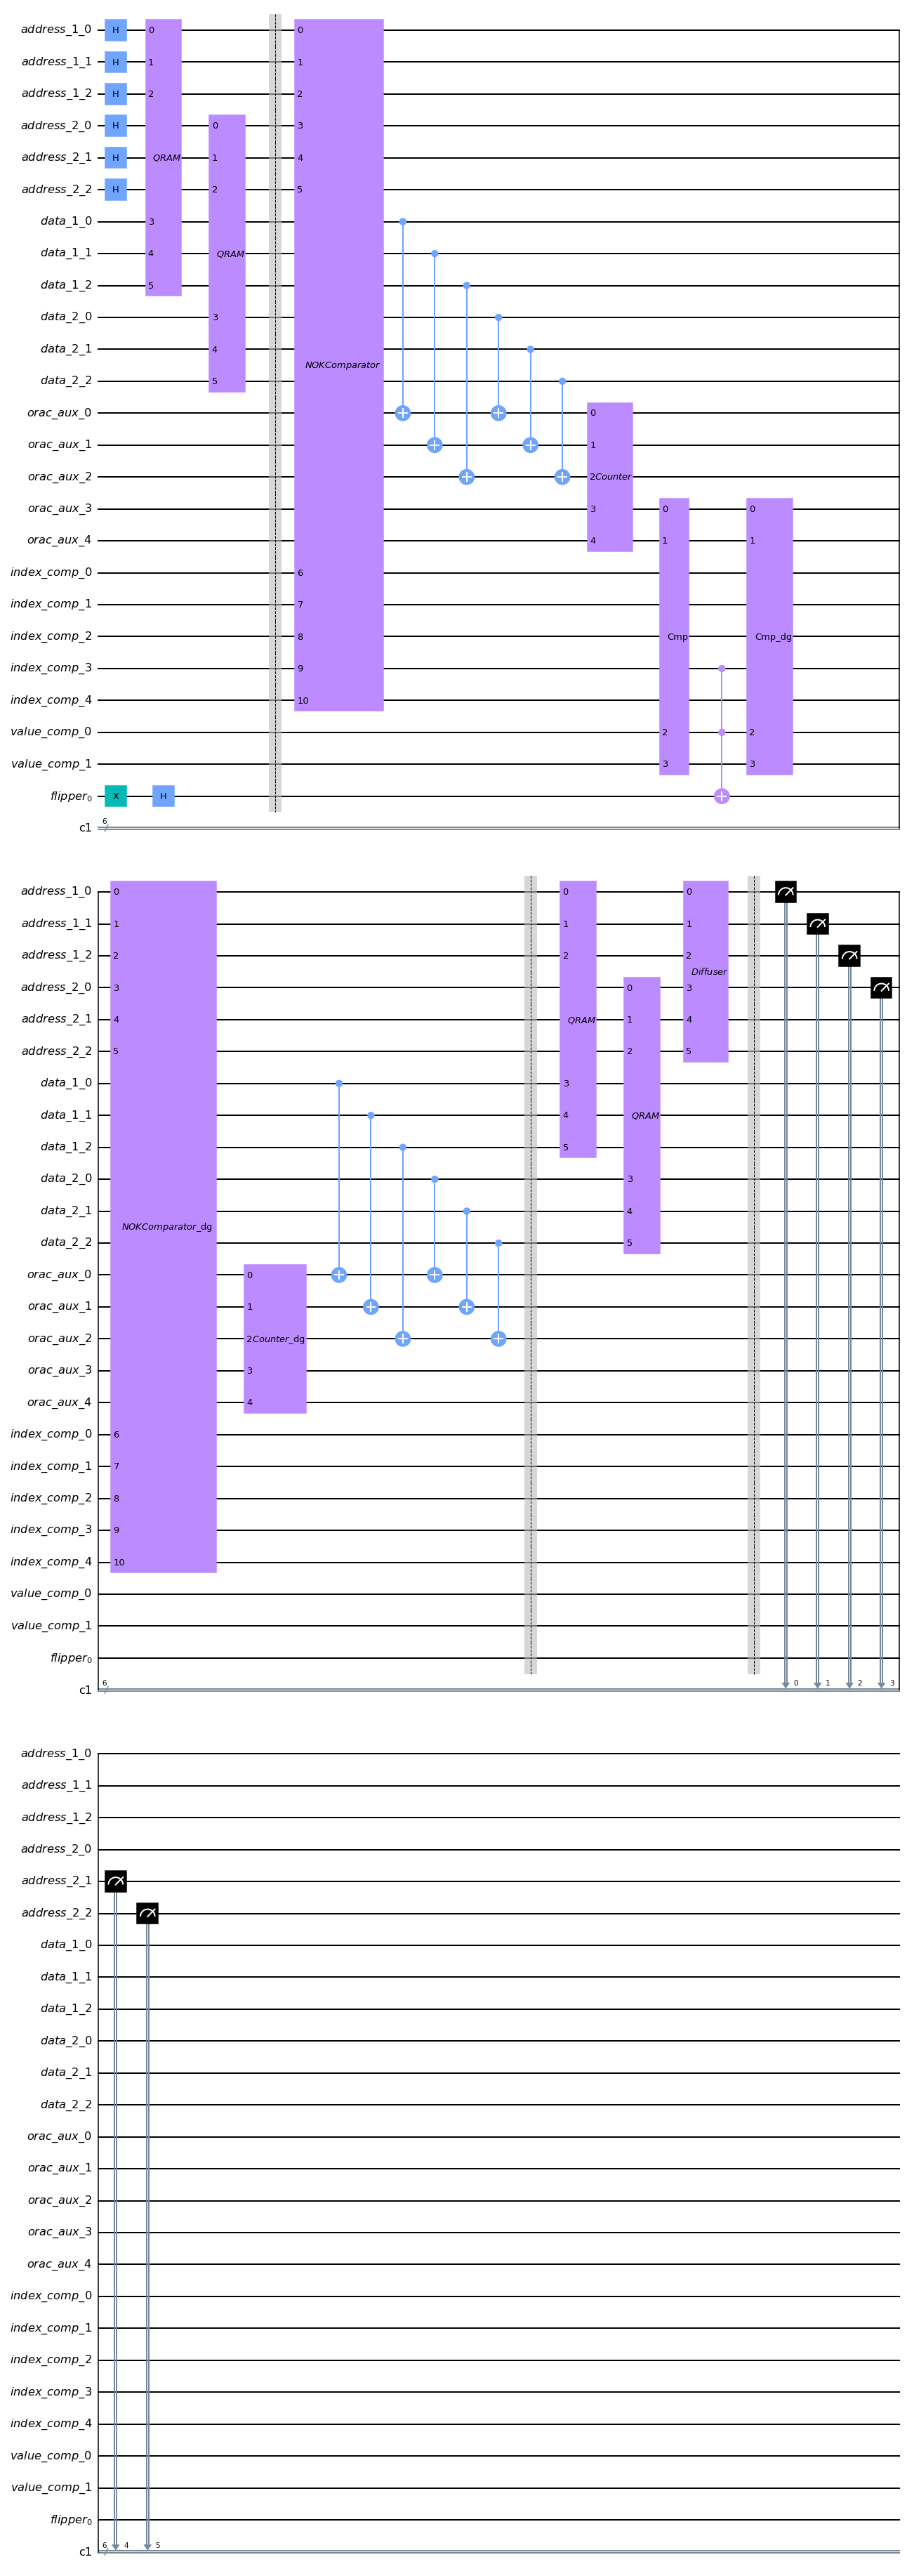

In [11]:
qc.draw()